# Downloading dataset

In [1]:
# Download and untar data
!wget -q -O "dakshina_dataset_v1.0.tar" "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar" 
!tar -xf dakshina_dataset_v1.0.tar
!rm dakshina_dataset_v1.0.tar

In [2]:
# The folder containing the datasets to be used in this program
!ls dakshina_dataset_v1.0/hi/lexicons
!wc -l dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv
!wc -l dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv
!wc -l dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv
!cat dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv | head

hi.translit.sampled.dev.tsv   hi.translit.sampled.train.tsv
hi.translit.sampled.test.tsv
44204 dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv
4502 dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv
4358 dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv
अं	an	3
अंकगणित	ankganit	3
अंकल	uncle	4
अंकुर	ankur	4
अंकुरण	ankuran	3
अंकुरित	ankurit	3
अंकुश	aankush	1
अंकुश	ankush	3
अंग	ang	2
अंग	anga	1
cat: write error: Broken pipe


In [3]:
from __future__ import print_function

import os
import csv
import yaml
import json
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
import tensorflow.keras as keras
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.layers import Layer
import keras.backend as K

import wandb
from wandb.keras import WandbCallback

from IPython.display import display
from IPython.display import HTML as html_print


from ipywidgets import interact, Layout, IntSlider
import ipywidgets as widgets

# Reading and processing data

In [4]:

os.environ["WANDB_API_KEY"] = "f058e3418fb166c3bee2d5131ef0bcc4b642793f"

START_CHAR   = '\t'
END_CHAR     = '\n'
BLANK_CHAR   = ' '
ln           = 'hi'

root      = f"dakshina_dataset_v1.0/{ln}/lexicons/"
train_dir = f"dakshina_dataset_v1.0/{ln}/lexicons/{ln}.translit.sampled.train.tsv"
test_dir  = f"dakshina_dataset_v1.0/{ln}/lexicons/{ln}.translit.sampled.test.tsv"
val_dir   = f"dakshina_dataset_v1.0/{ln}/lexicons/{ln}.translit.sampled.dev.tsv"

In [5]:
def read_data(data_path, characters = False):
    # Returns the (input, output) pair from the dataset
    # If characters == True, the input/output sample would be in the form list of characters, else as string

    with open(data_path, "r", encoding="utf-8") as f:
        lines = [line.split("\t") for line in f.read().split("\n") if line != '']
    
    input, target = [val[1] for val in lines], [val[0] for val in lines]
    if characters:
        input, target = [list(inp_str) for inp_str in input], [list(tar_str) for tar_str in target]
    return input, target


def process_data(input, enc_timesteps, input_char_enc, target = None, dec_timesteps = None, target_char_enc = None):
    # Returns the input and target data in a form needed by the Keras embedding layer (i.e) 
    # decoder_input & encoder_input -- (None, timesteps) where each character is encoded by an integer
    # decoder_output -- (None, timesteps, vocabulary size) where the last dimension is the one-hot encoding

    # BLANK_CHAR -- space (equivalent to no meaningful input / blank input)
    encoder_input = np.array([[input_char_enc[ch] for ch in string] + [input_char_enc[BLANK_CHAR]] * (enc_timesteps - len(string)) for string in input])

    decoder_input, decoder_target = None, None
    if target is not None and dec_timesteps is not None and target_char_enc is not None:
        # START_CHAR -- start of sequence, END_CHAR -- end of sequence
        decoder_input = np.array([[target_char_enc[START_CHAR]] + [target_char_enc[ch] for ch in string] + [target_char_enc[END_CHAR]] 
                                    + [target_char_enc[BLANK_CHAR]] * (dec_timesteps - len(string) - 2) for string in target])
        decoder_target = np.zeros((decoder_input.shape[0], dec_timesteps, len(target_char_enc)), dtype='float32')

        for i in range(decoder_input.shape[0]):
            for t, char_ind in enumerate(decoder_input[i]):
                if t > 0:
                    decoder_target[i,t-1,char_ind] = 1.0
            decoder_target[i,t:,target_char_enc[BLANK_CHAR]] = 1.0

    return encoder_input, decoder_input, decoder_target


def encode_decode_characters(train_input, train_target, val_input, val_target):
    # Returns the encoding for characters to integer (as a dictionary) and decoding for integers to characters (as a list) for input and target data

    # Encoding and decoding of input vocabulary
    input_char_enc = {}
    input_char_dec = []
    max_encoder_seq_length = 1
    for string in train_input + val_input:
        max_encoder_seq_length = max(max_encoder_seq_length, len(string))
        for char in string:
            if char not in input_char_enc:
                input_char_enc[char] = len(input_char_dec)
                input_char_dec.append(char)
    if BLANK_CHAR not in input_char_enc:
        input_char_enc[BLANK_CHAR] = len(input_char_dec)
        input_char_dec.append(BLANK_CHAR)

    # Encoding and decoding of target vocabulary
    target_char_enc = {}
    target_char_dec = []
    target_char_enc[START_CHAR] = len(target_char_dec)
    target_char_dec.append(START_CHAR)
    max_decoder_seq_length = 1
    for string in train_target + val_target:
        max_decoder_seq_length = max(max_decoder_seq_length, len(string)+2)
        for char in string:
            if char not in target_char_enc:
                target_char_enc[char] = len(target_char_dec)
                target_char_dec.append(char)
    target_char_enc[END_CHAR] = len(target_char_dec)
    target_char_dec.append(END_CHAR)
    if ' ' not in target_char_enc:
        target_char_enc[BLANK_CHAR] = len(target_char_dec)
        target_char_dec.append(BLANK_CHAR)

    print("Number of training samples:", len(train_input))
    print("Number of validation samples:", len(val_input))
    print("Number of unique input tokens:", len(input_char_dec))
    print("Number of unique output tokens:", len(target_char_dec))
    print("Max sequence length for inputs:", max_encoder_seq_length)
    print("Max sequence length for outputs:", max_decoder_seq_length)

    return input_char_enc, input_char_dec, target_char_enc, target_char_dec, max_encoder_seq_length, max_decoder_seq_length

In [6]:
input_char_enc = {}
input_char_dec = []
target_char_enc = {}
target_char_dec = []
max_encoder_seq_length = 0
max_decoder_seq_length = 0


# Reading training, validation and test data
train_inp, train_out = read_data('./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv')
val_inp, val_out = read_data('./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv')
test_inp, test_out = read_data('./dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv')


# Assigning encoding and decoding for input and target characters
input_char_enc, input_char_dec, target_char_enc, target_char_dec, max_encoder_seq_length, max_decoder_seq_length = encode_decode_characters(
    train_inp, train_out, val_inp, val_out)

# Assigning training, validation and test encoder input, decoder input, decoder output
train_enc_input, train_dec_input, train_dec_target = process_data(train_inp, max_encoder_seq_length, input_char_enc, train_out, 
                                                                  max_decoder_seq_length, target_char_enc)
val_enc_input, val_dec_input, val_dec_target = process_data(val_inp, max_encoder_seq_length, input_char_enc, val_out, 
                                                            max_decoder_seq_length, target_char_enc)
test_enc_input, test_dec_input, test_dec_target = process_data(test_inp, max_encoder_seq_length, input_char_enc, test_out, 
                                                               max_decoder_seq_length, target_char_enc)


Number of training samples: 44204
Number of validation samples: 4358
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [7]:
def convert_to_word(predictions, char_enc, char_dec = None):
    # Function to return the predictions after cutting the END_CHAR and BLANK_CHAR s at the end.
    # If char_dec == None, the predictions are in the form of decoded string, otherwise as list of integers
    no_samples = len(predictions) if type(predictions) is list else predictions.shape[0]
    pred_words = ['' for _ in range(no_samples)]
    for i, pred_list in enumerate(predictions):
        for l in pred_list:
            # Stop word : END_CHAR
            if l == char_enc[END_CHAR]:
                break
            pred_words[i] += char_dec[l] if char_dec is not None else l
    
    return pred_words

def levenshtein(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(
                    1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

# Logging into W&B

In [8]:
!wandb login f058e3418fb166c3bee2d5131ef0bcc4b642793f

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:

def beam_decoder_infer(model, input_seqs, max_decoder_timesteps, K=1, target_seqs=None, starting_char_enc=0, batch_size=64, attention=False):
    '''
    Function to do inference on the model using beam decoder.
    Arguments :
        model -- (Keras model object) training model
        input_seqs -- (numpy ndarray of size : (None, timesteps)) input to encoder
        max_decoder_timesteps -- (int) Number of timesteps to infer in decoder
        K -- (int, default : 1) beam width of beam decoder
        target_seqs -- (numpy ndarray of size : (None, timesteps, decoder_vocab_size), deault : None) expected target.
                       If None, cross entropy errors won't be calculated.
        starting_char_enc -- (int, default : 0) Encoding integer for START_CHAR
        batch_size -- (int, default : 64) batch_size sent to Keras predict
        attention -- (bool, defualt : False) whether the model has attention or not
    Returns :
        final_outputs -- (numpy ndarray of size : (None, K, timesteps)) top K output sequences
        final_errors -- (numpy ndarray of size : (None, K)) cross entropy errors for top K output (All zeros if target_seqs == None)
        states_values -- (numpy ndarray of size : (K, None, timesteps, hid_layer_size))  hidden states of decoder
        final_attn_scores -- (numpy ndarray of size : (None, K, decoder_timesteps, encoder_timesteps)) attention to all encoder timesteps for a decoder timestep 
    '''

    encoder_model, decoder_model, no_enc_layers, no_dec_layers = create_attention_inference_model(model)
    encoder_output = encoder_model.predict(input_seqs, batch_size=batch_size)
    encoder_out = encoder_output if type(encoder_output) is list else [encoder_output]

    # Number of input samples in the data passed
    no_samples = input_seqs.shape[0]

    # Top K output sequences for each input
    final_outputs = np.zeros(
        (no_samples, K, max_decoder_timesteps), dtype=np.int32)
    # Errors for top K output sequences for each input
    final_errors = np.zeros((no_samples, K))
    # Attention scores for top K output sequences for each input
    final_attn_scores = np.zeros(
        (no_samples, K, max_decoder_timesteps, input_seqs.shape[1]))

    # decoder input sequence for 1 timestep (for all samples). Initially one choice only there
    decoder_k_inputs = np.zeros((no_samples, 1, 1))
    # Populate the input sequence with the start character at the 1st timestep
    decoder_k_inputs[:, :, 0] = starting_char_enc

    # (log(probability) sequence, decoder output sequence) pairs for all choices and all samples. Probability starts with log(1) = 0
    decoder_k_out = [[(0, [])] for _ in range(no_samples)]
    # Categorical cross entropy error in the sequence for all choice and all samples
    errors = [[0] for _ in range(no_samples)]
    # Output states from decoder for all choices, and all samples
    states_values = [encoder_out * no_dec_layers]

    # Attention weights output
    attn_k_scores = [[None] for _ in range(no_samples)]

    # Sampling loop
    for it in range(max_decoder_timesteps):
        # Storing respective data for all possibilities
        All_k_beams = [[] for _ in range(no_samples)]
        All_decoder_states = [[] for _ in range(no_samples)]
        All_errors = [[] for _ in range(no_samples)]
        All_attn_scores = [[] for _ in range(no_samples)]

        for k in range(len(decoder_k_out[0])):
            if attention:
                attn_score, decoder_output, *decoder_states = decoder_model.predict(
                    [input_seqs, decoder_k_inputs[:, k]] + states_values[k], batch_size=batch_size)
            else:
                decoder_output, *decoder_states = decoder_model.predict(
                    [decoder_k_inputs[:, k]] + states_values[k], batch_size=batch_size)

            # Top K scores
            top_k = np.argsort(decoder_output[:, -1, :], axis=-1)[:, -K:]
            for b in range(no_samples):
                All_k_beams[b] += [(
                    decoder_k_out[b][k][0] +
                    np.log(decoder_output[b, -1, top_k[b][i]]),
                    decoder_k_out[b][k][1] + [top_k[b][i]]
                ) for i in range(K)]

                if attention:
                    All_attn_scores[b] += [attn_score[b]] * K if attn_k_scores[b][k] is None else [
                        np.concatenate((attn_k_scores[b][k], attn_score[b]), axis=0)] * K

                if target_seqs is not None:
                    All_errors[b] += [errors[b][k] -
                                      np.log(decoder_output[b, -1, target_seqs[b, it]])] * K

                All_decoder_states[b] += [[state[b:b+1]
                                           for state in decoder_states]] * K

        # Sort and choose top K with max probabilities
        sorted_ind = list(range(len(All_k_beams[0])))
        sorted_ind = [sorted(sorted_ind, key=lambda ix: All_k_beams[b]
                             [ix][0])[-K:][::-1] for b in range(no_samples)]
        # Choose the top K decoder output sequences till now
        decoder_k_out = [[All_k_beams[b][ind]
                          for ind in sorted_ind[b]] for b in range(no_samples)]

        # Update the input sequence for next 1 timestep
        decoder_k_inputs = np.array(
            [[All_k_beams[b][ind][1][-1] for ind in sorted_ind[b]] for b in range(no_samples)])

        # Update states
        states_values = [All_decoder_states[0][ind] for ind in sorted_ind[0]]
        for b in range(1, no_samples):
            states_values = [[np.concatenate((states_values[i][j], All_decoder_states[b][ind][j]))
                              for j in range(len(All_decoder_states[b][ind]))] for i, ind in enumerate(sorted_ind[b])]

        # Update attention scores
        if attention:
            attn_k_scores = [[All_attn_scores[b][ind]
                              for ind in sorted_ind[b]] for b in range(no_samples)]

        # Update errors
        if target_seqs is not None:
            errors = [[All_errors[b][ind] for ind in sorted_ind[b]]
                      for b in range(no_samples)]

    final_outputs = np.array([[decoder_k_out[b][i][1]
                             for i in range(K)] for b in range(no_samples)])
    if target_seqs is not None:
        final_errors = np.array(errors) / max_decoder_timesteps
    if attention:
        final_attn_scores = np.array(attn_k_scores)

    return final_outputs, final_errors, np.array(states_values), final_attn_scores


def calc_metrics(k_outputs, target_seqs, char_enc, char_dec, k_errors=None, exact_word=True):
    # Calculates the accuracy (and mean error if info provided) for the best of K possible output sequences
    # target_seqs -- Expected output (encoded sequence)
    # k_outputs -- k choices of output sequences for each sample

    matches = np.mean(k_outputs == np.repeat(target_seqs.reshape(
        (target_seqs.shape[0], 1, target_seqs.shape[1])), k_outputs.shape[1], axis=1), axis=-1)
    best_k = np.argmax(matches, axis=-1)
    best_ind = (tuple(range(best_k.shape[0])), tuple(best_k))
    accuracy = np.mean(matches[best_ind])

    loss = None
    if k_errors is not None:
        loss = np.mean(k_errors[best_ind])
    if exact_word:
        equal = [0] * k_outputs.shape[0]
        true_out = convert_to_word(target_seqs, char_enc, char_dec)
        for k in range(k_outputs.shape[1]):
            pred_out = convert_to_word(k_outputs[:, k], char_enc, char_dec)
            equal = [equal[i] or (pred_out[i] == true_out[i])
                     for i in range(k_outputs.shape[0])]
        exact_accuracy = np.mean(equal)

        return accuracy, exact_accuracy, loss

    return accuracy, loss


def beam_decoder(model, input_seqs, target_seqs_onehot, max_decoder_timesteps, char_enc, char_dec, K=1,
                 model_batch_size=64, attention=False, infer_batch_size=512, exact_word=True, return_outputs=False,
                 return_states=False, return_attn_scores=False):
    '''
    Function to calculate/capture character-wise accuracy, exact-word-match accuracy, and loss for the seq2seq model using a beam decoder.
    Arguments :
        model -- (Keras model object) model used for training
        input_seqs -- (numpy ndarray of size : (None, timesteps)) input to encoder (where characters are encoded as integers)
        target_seqs -- (numpy ndarray of size : (None, timesteps, decoder_vocab_size)) expected target in onehot format
        max_decoder_timesteps -- (int) Number of timesteps to infer in decoder
        char_enc -- (dict) target character encoding
        char_dec -- (list) target character decoding
        K -- (int, default : 1) beam width to be used in beam decoder
        model_batch_size -- (int, default : 64) batch size to be used while evaluating model using Keras
        attention -- (bool, defualt : False) whether the model has attention or not
        infer_batch_size -- (int, default : 512) number of samples to be sent to beam_decoder_infer() at a time (to avoid RAM memory overshoot problems).
                            We have set the default model_batch_size and infer_batch_size such that it takes the least time to run and runs without problems in Google Colab.
        exact_word -- (bool, default : True) whether or not exact_accuracy has (If True, will be returned as the next argument after accuracy)
        return_outputs -- (bool, default : True) whether or not the outputs predicted need to be returned
        return_states -- (bool, default : True) whether or not the decoder hidden states need to be returned (for further training, another sequential model addition, etc)
        return_attn_scores -- (bool, default : True) whether or not the attention scores need to be returned
    Returns :
        accuracy -- (float) the character-wise match accuracy (as calculated by Keras fit)
        (If exact_word is True) exact_accuracy -- (float) the exact word match accuracy
        loss -- (float) the cross-entropy loss for the top K predictions
        (If return_outputs is True) k_outputs -- (numpy ndarray of size : (None, K, timesteps)) top K output sequences
        (If return_states is True) k_states -- (numpy ndarray of size : (K, None, timesteps, hid_layer_size))  hidden states of decoder
        (If return_attn_scores is True) k_attn_scores -- (numpy ndarray of size : (None, K, decoder_timesteps, encoder_timesteps)) attention scores
    '''
    target_seqs = np.argmax(target_seqs_onehot, axis=-1)
    k_outputs, k_errors, k_states, k_attn_scores = None, None, None, None
    for i in range(0, input_seqs.shape[0], infer_batch_size):
        tmp_k_outputs, tmp_k_errors, tmp_k_states, tmp_k_attn_scores = beam_decoder_infer(model, input_seqs[i:i+infer_batch_size],
                                                                                          max_decoder_timesteps, K,
                                                                                          target_seqs[i:i +
                                                                                                      infer_batch_size], char_enc['\t'],
                                                                                          model_batch_size, attention)
        if k_errors is None:
            k_outputs, k_errors, k_states, k_attn_scores = tmp_k_outputs, tmp_k_errors, tmp_k_states, tmp_k_attn_scores
        else:
            k_outputs = np.concatenate((k_outputs, tmp_k_outputs))
            k_errors = np.concatenate((k_errors, tmp_k_errors))
            k_states = np.concatenate((k_states, tmp_k_states), axis=2)
            k_attn_scores = np.concatenate((k_attn_scores, tmp_k_attn_scores))

    return_elements = []
    if return_outputs:
        return_elements += [k_outputs]
    if return_states:
        return_elements += [k_states]
    if return_attn_scores:
        return_elements += [k_attn_scores]

    if len(return_elements) > 0:
        return calc_metrics(k_outputs, target_seqs, char_enc, char_dec, k_errors, exact_word) + tuple(return_elements)

    return calc_metrics(k_outputs, target_seqs, char_enc, char_dec, k_errors, exact_word)



# Seq2Seq Model (with Attention)

In [10]:


class AttentionLayer(Layer):
    """
    This Attention layer class code is used from : https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            # (batch_size, decoder_timesteps, decoder_hid_layer_size)
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            # (batch_size, decoder_timesteps, encoder_timesteps)
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

### Creating model (with attention)

In [11]:
def create_attention_model(encoder_vocab_size, decoder_vocab_size, inp_emb_size=64, no_enc_layers=1, no_dec_layers=1, 
                           hid_layer_size=64, cell_type='LSTM', dropout=0, r_dropout=0, cell_activation='tanh'):
    '''
    Function to create a seq2seq model with attention.
    Arguments :
        encoder_vocab_size -- (int) number of characters in input vocabulary
        decoder_vocab_size -- (int) number of characters in output vocabulary
        inp_emb_size -- (int, default : 64) size of input embedding layer for encoder and decoder
        no_enc_layers -- (int, default : 1) number of layers of cell to stack in encoder
        no_dec_layers -- (int, default : 1) number of layers of cell to stack in decoder
        hid_layer_size -- (int, default : 64) size of hidden layer of the encoder and decoder cells
        cell_type -- (string, default : 'LSTM') type of cell used in encoder and decoder (possible values : 'LSTM', 'GRU', 'RNN')
        dropout -- (float, default : 0.0) value of normal dropout (between 0 and 1)
        r_dropout -- (float, default : 0.0) value of recurrent dropout (between 0 and 1)
        cell_activation -- (string, default : 'tanh') type of activation used in the cell (as required by Keras)
    Returns :
        model -- (Keras model object) resulting attention model
    '''
    # Getting cell type
    get_cell = {
        'RNN': keras.layers.SimpleRNN,
        'GRU': keras.layers.GRU,
        'LSTM': keras.layers.LSTM
    }
    # Encoder input and embedding
    encoder_input = keras.layers.Input(shape=(None,), name="input_1")
    encoder_inp_emb = keras.layers.Embedding(encoder_vocab_size, inp_emb_size, name="embedding_1")(encoder_input)

    # Encoder cell layers
    encoder_seq, *encoder_state = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                                      dropout=dropout, recurrent_dropout=r_dropout, name="encoder_1")(
                                                            encoder_inp_emb
                                                     )
    for i in range(1, no_enc_layers):
        encoder_seq, *encoder_state = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                                          dropout=dropout, recurrent_dropout=r_dropout, name="encoder_"+str(i+1))(
                                                                encoder_seq
                                                         )
    # Decoder input and embedding
    decoder_input = keras.layers.Input(shape=(None,), name="input_2")
    decoder_inp_emb = keras.layers.Embedding(decoder_vocab_size, inp_emb_size, name="embedding_2")(decoder_input)
    decoder_seq = decoder_inp_emb
    # Decoder cell layers
    for i in range(no_dec_layers-1):
        decoder_seq, *_ = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                              dropout=dropout, recurrent_dropout=r_dropout, name="decoder_"+str(i+1))(
                                                    decoder_seq, initial_state=encoder_state
                                             )
    # Decoder last layer
    decoder_seq, *_ = get_cell[cell_type](hid_layer_size, activation=cell_activation, return_sequences=True, return_state=True, 
                                          dropout=dropout, recurrent_dropout=r_dropout, name="decoder_1")(
                                                decoder_inp_emb, initial_state=encoder_state
                                         )

    # Attention layer
    attn_out, attn_scores = AttentionLayer(name='attention_1')([encoder_seq, decoder_seq])        # Bahdanau Attention
    # Concat attention output and decoder output
    dense_concat_input = keras.layers.Concatenate(axis=-1, name='concat_layer_1')([decoder_seq, attn_out])

    # Time distributed Softmax FC layer
    decoder_dense_layer = keras.layers.Dense(decoder_vocab_size, activation="softmax", name="dense_1")
    decoder_dense_output = decoder_dense_layer(dense_concat_input)

    # Define the model that will turn encoder_input_data and decoder_input_data into decoder_target_data
    model = keras.Model([encoder_input, decoder_input], decoder_dense_output)

    model.summary(line_length=150)
    return model

### Inference Model (with attention)

In [12]:
def create_attention_inference_model(model):
    '''
    Function to return models needed for inference from the original model (with attention).
    Arguments :
        model -- (Keras model object) attention model used for training
    Returns :
        encoder_model -- (Keras model object) 
        deocder_model -- (Keras model object)
        no_enc_layers -- (int) number of layers in the encoder
        no_dec_layers -- (int) number of layers in the decoder
    '''
    # Calculating number of layers in encoder and decoder
    no_enc_layers, no_dec_layers = 0, 0
    for layer in model.layers:
        no_enc_layers += layer.name.startswith('encoder')
        no_dec_layers += layer.name.startswith('decoder')

    # Encoder input
    encoder_input = model.input[0]      # Input_1
    # Encoder cell final layer
    encoder_cell = model.get_layer("encoder_"+str(no_enc_layers))
    encoder_type = encoder_cell.__class__.__name__
    encoder_seq, *encoder_state = encoder_cell.output
    # Encoder model
    encoder_model = keras.Model(encoder_input, encoder_state)

    # Decoder input
    decoder_input = model.input[1]      # Input_2
    decoder_inp_emb = model.get_layer("embedding_2")(decoder_input)
    decoder_seq = decoder_inp_emb
    # Inputs to decoder layers' initial states
    decoder_states, decoder_state_inputs = [], []
    for i in range(1, no_dec_layers+1):
        if encoder_type == 'LSTM':
            decoder_state_input = [keras.Input(shape=(encoder_state[0].shape[1],), name="input_"+str(2*i+1)), 
                                   keras.Input(shape=(encoder_state[1].shape[1],), name="input_"+str(2*i+2))]
        else:
            decoder_state_input = [keras.Input(shape=(encoder_state[0].shape[1],), name="input_"+str(i+2))]

        decoder_cell = model.get_layer("decoder_"+str(i))
        decoder_seq, *decoder_state = decoder_cell(decoder_seq, initial_state=decoder_state_input)
        decoder_states += decoder_state
        decoder_state_inputs += decoder_state_input

    # Attention layer
    attn_out, attn_scores = model.get_layer('attention_1')([encoder_seq, decoder_seq])        # Bahdanau Attention
    # Concat attention input and decoder output
    dense_concat_input = keras.layers.Concatenate(axis=-1, name='concat_layer_1')([decoder_seq, attn_out])

    # Softmax FC layer
    decoder_dense = model.get_layer("dense_1")
    decoder_dense_output = decoder_dense(dense_concat_input)

    # Decoder model
    decoder_model = keras.Model(
        [encoder_input, decoder_input] + decoder_state_inputs, [attn_scores, decoder_dense_output] + decoder_states
    )

    return encoder_model, decoder_model, no_enc_layers, no_dec_layers

### Model training (with attention)

In [13]:
class custom_validator(keras.callbacks.Callback):
    # Custom class to provide callback after each epoch of training to calculate custom metrics for validation set with beam decoder
    def __init__(self, val_enc_input, val_dec_target, beam_width=1, batch_size=64, attention=False):
        self.beam_width = beam_width
        self.validation_input = val_enc_input
        self.validation_target = val_dec_target
        self.batch_size = batch_size
        self.attention = attention

    def on_epoch_end(self, epoch, logs):
        val_accuracy, val_exact_accuracy, val_loss = beam_decoder(self.model, self.validation_input, self.validation_target, max_decoder_seq_length, 
                                                                  target_char_enc, target_char_dec, self.beam_width, self.batch_size, self.attention)

        # Log them to reflect in WANDB callback and EarlyStopping
        logs["val_accuracy"] = val_accuracy
        logs["val_exact_accuracy"] = val_exact_accuracy
        logs["val_loss"] = val_loss             # Validation loss calculates categorical cross entropy loss

        print("— val_loss: {:.4f} — val_accuracy: {:.4f} — val_exact_accuracy: {:.4f}".format(val_loss, val_accuracy, val_exact_accuracy))


In [14]:
def train_model(model, train_input_data, train_target_data, val_input_data, val_target_data, beam_width = 1, attention = False,
                batch_size = 64, optimizer = 'adam', learning_rate = 1e-3, epochs = 10, loss_fn = 'categorical_crossentropy'):
        
    get_optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'momentum': SGD(learning_rate=learning_rate, momentum=0.9),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'nesterov': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
        'nadam': Nadam(learning_rate=learning_rate),
    }


    model.compile(
        optimizer=get_optimizer[optimizer], loss=loss_fn, metrics=['accuracy'])


    # Using validation accuracy as the metric to monitor as that is what is intended to be maximized
    model.fit(train_input_data,
              train_target_data,
              batch_size = batch_size,
              epochs = epochs, 
              verbose = 2,
              callbacks = [custom_validator(val_input_data[0], val_target_data, beam_width, batch_size, attention), 
                           WandbCallback(monitor='val_accuracy'), EarlyStopping(monitor='val_accuracy', patience=5)])

    return model

In [15]:

config_2 = {
    "learning_rate": 1e-3,                                      
    "epochs": 1,                                                  
    "optimizer": 'adam',                                        
    "batch_size": 64,                                           
    "loss_function": 'categorical_crossentropy',                
    "architecture": 'RNN',                                      
    "dataset": "Dakshina",                                      
    "inp_emb_size": 256,                                        
    "no_enc_layers": 1,                                         
    "no_dec_layers": 1,                                         
    "hid_layer_size": 256,                                      
    "dropout" : 0.25,                                           
    "cell_type": 'LSTM',                                        
    "beam_width": 5,                                            
    "attention": True                                           
}

def seq2seq_attention(config, load_model=None, wandb_init=True):
  '''
  Function to load/create a model (with attention) and train it.
  Arguments :
    config -- (dict) configurations of parameters and hyperparameters ot be used for creating the model. if load_model is not None, this isn't necessary.
                (the dictionary should contain the keys that are mentioned in config_1)
    load_model -- (string, default : None) WANDB run ID of the model to train further. The configurations will be read from WANDB as well.
    wandb_init -- (bool, default : True) whther or not WANDB run needs to be initiated (if this function is used as part of sweep alone, this would be False)
  Returns :
    model -- (Keras model object) trained model
    config -- (dict) configuration dictionary
    id -- (string) WANDB run ID used for training the model
  '''

  if load_model is not None:    
    prev_run = wandb.Api().run('ms20/A3/'+load_model)
    prev_model_file = prev_run.file('model-best.h5').download(replace=True)
    model = keras.models.load_model(prev_model_file.name, custom_objects={'AttentionLayer': AttentionLayer})
    config_file = prev_run.file('config.yaml').download(replace=True)
    with open(config_file.name, 'r') as file:
      config_tmp = yaml.safe_load(file)
    config = {}
    config['attention'] = True
    for key in ['learning_rate', 'epochs', 'optimizer', 'batch_size', 'loss_function', 'architecture', 'dataset', 'inp_emb_size', 'no_enc_layers', \
                'no_dec_layers', 'hid_layer_size', 'dropout', 'cell_type', 'beam_width']:
      config[key] = config_tmp[key]['value']
  else:
    model = create_attention_model(len(input_char_dec), len(target_char_dec), config['inp_emb_size'], config['no_enc_layers'], 
                                   config['no_dec_layers'], config['hid_layer_size'], config['cell_type'], config['dropout'], config['dropout'])
  
  id = None
  if wandb_init:
    id = wandb.util.generate_id()
    run = wandb.init(id = id, project="assignment3", entity="abisheks", reinit=True, config=config)
    wandb.run.name = f"ie_{config['inp_emb_size']}_ne_{config['no_enc_layers']}_de_{config['no_dec_layers']}_ct_{config['cell_type']}_dr_{config['dropout']}"
    wandb.run.name += f"_da_{config['hid_layer_size']}_K_{config['beam_width']}_attn_{True}"
    wandb.run.save()
    print(wandb.run.name)
  
  model = train_model(model, [train_enc_input,train_dec_input], train_dec_target, [val_enc_input,val_dec_input], val_dec_target, config['beam_width'],
                      config['attention'], config['batch_size'], config['optimizer'], config['learning_rate'], config['epochs'], config['loss_function'])
  
  if wandb_init:
    run.finish()

  return model, config, id


### Sweep (models with attention)

In [16]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

def attention_sweep_wrapper():
    run = wandb.init(config=config_2, reinit=True)
    config = wandb.config

    wandb.run.name = f'ie_{config.inp_emb_size}_ne_{config.no_enc_layers}_de_{config.no_dec_layers}_ct_{config.cell_type}_dr_{config.dropout}'
    wandb.run.name += f'_da_{config.hid_layer_size}_K_{config.beam_width}'
    wandb.run.save()
    print(wandb.run.name)

    model, *_ = seq2seq_attention(config, wandb_init=False)
    run.finish()

2022-05-23 10:49:40.548365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 10:49:40.699954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 10:49:40.701084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [17]:
sweep_config_2 = {
    'name': 'w_attn',
    'method': 'bayes',                  
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'inp_emb_size': {
            'values': [32, 64, 256]
        },
        'no_enc_layers': {
            'values': [1, 2, 3]
        },
        'no_dec_layers': {
            'values': [1, 2, 3]
        },
        'hid_layer_size': {
            'values': [32, 64, 256]
        },
        'cell_type': {
            'values': ['RNN', 'LSTM', 'GRU']
        },
        'dropout' :{
            'values': [0, 0.25, 0.4]
        },
        'beam_width': {
            'values': [1, 5]
        }
    }
}

sweep_id = wandb.sweep(sweep_config_2, project="A3", entity="ms20")
wandb.agent(sweep_id, attention_sweep_wrapper, count=1)

Create sweep with ID: 0f2723j4
Sweep URL: https://wandb.ai/ms20/A3/sweeps/0f2723j4


wandb: Agent Starting Run: 1tlu5f49 with config:
wandb: 	beam_width: 5
wandb: 	cell_type: GRU
wandb: 	dropout: 0
wandb: 	hid_layer_size: 32
wandb: 	inp_emb_size: 32
wandb: 	no_dec_layers: 3
wandb: 	no_enc_layers: 2
wandb: Currently logged in as: cookie303 (ms20). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


ie_32_ne_2_de_3_ct_GRU_dr_0_da_32_K_5


2022-05-23 10:49:51.247870: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-23 10:49:51.248416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 10:49:51.249653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 10:49:51.250880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, None)]                   0                                                                   
______________________________________________________________________________________________________________________________________________________
embedding_1 (Embedding)                          (None, None, 32)                 864               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
input_2 (InputLayer)                             [(None, None)]                

2022-05-23 10:49:57.026937: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-23 10:50:04.595723: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


691/691 - 77s - loss: 1.2033 - accuracy: 0.7134
— val_loss: 1.3665 — val_accuracy: 0.7286 — val_exact_accuracy: 0.0000


accuracy,▁
epoch,▁
loss,▁
val_accuracy,▁
val_exact_accuracy,▁
val_loss,▁
accuracy,0.71345
best_epoch,0
best_val_accuracy,0.72862
epoch,0
loss,1.20328


### Test accuracy and sample input/output for best model (with attention)

In [18]:
def test_model(run_id, test_enc_input, test_dec_target, max_decoder_seq_length, target_char_enc, target_char_dec, attention=False, save_pred=False, test_input=None):
    '''
    Function to evaluate the model metrics on test data and optionally save the predictions.
    Arguments :
        run_id -- (string) WANDB run ID for the trained model
        test_enc_input -- (numpy ndarray of size : (None, timesteps)) input to encoder (where characters are encoded as integers)
        test_dec_target -- (numpy ndarray of size : (None, timesteps, decoder_vocab_size)) expected target in onehot format
        max_decoder_seq_length -- (int) number of timesteps in the decoder
        target_enc_enc -- (dict) target character encoding
        target_char_dec -- (list) target character decoding
        attention -- (bool, default : False) whether or not the model uses attention
        save_pred -- (bool, default : False) whether or not to save the predictions in a csv file
        test_input -- (list of string : (no_samples, input word), default : None) input as words (needed while saving predictions to file alone)
    Returns :
        acc -- (float) character-wise match accuracy
        exact_K_acc -- (float) exact word match accuracy using the beam width for the model
        exact_acc -- (float) exact word match accuracy using the first prediction (which is equivalent to beam width = 1)
        loss -- (float) loss value
        true_out -- (list of string : (no_samples, word)) true output  
        pred_out -- (2D list of string : (no_samples, K, word)) predicted output
        pred_scores -- (2D list : (no_samples, K)) levenshtein distance of prediction to true output
        (If attention is True) attn_scores -- (numpy ndarray of size : (None, K, decoder_timesteps, encoder_timesteps)) attention scores
        model -- (Keras model object) the model obtained from the run
    '''
    api = wandb.Api()
    prev_run = api.run('ms20/A3/'+run_id)
    prev_model_file = prev_run.file('model-best.h5').download(replace=True)
    
    if attention:
        model = keras.models.load_model(prev_model_file.name, custom_objects={'AttentionLayer': AttentionLayer})
    else:
        model = keras.models.load_model(prev_model_file.name)
    config_file = prev_run.file('config.yaml').download(replace=True)
    with open(config_file.name, 'r') as file:
        config = yaml.safe_load(file)
        

    no_samples, K, batch_size = test_enc_input.shape[0], config['beam_width']['value'], config['batch_size']['value']
    acc, exact_K_acc, loss, outputs, attn_scores = beam_decoder(model, test_enc_input, test_dec_target, max_decoder_seq_length, target_char_enc, 
                                                                target_char_dec, K, batch_size, attention,
                                                                return_outputs=True, return_attn_scores=True)
    
    print(f'Test accuracy (using exact word match with beam width = {K}) : {exact_K_acc*100:.2f}%')

    test_target = np.argmax(test_dec_target, axis=-1)
    true_out = convert_to_word(test_target, target_char_enc, target_char_dec)
    pred_out = [[] for _ in range(no_samples)]
    pred_scores = [[] for _ in range(no_samples)]
    for k in range(K):
        pred = convert_to_word(outputs[:,k], target_char_enc, target_char_dec)
        pred_out = [pred_out[b] + [pred[b]] for b in range(no_samples)]
        pred_scores = [pred_scores[b] + [levenshtein(pred[b], true_out[b])] for b in range(no_samples)]
    
    equal = [pred_out[i][0] == true_out[i] for i in range(no_samples)]
    exact_acc = np.mean(equal)

    print(f'Test accuracy (using exact word match of the first prediction) : {exact_acc*100:.2f}%')
    print('\n')
    
    if save_pred:
        # We write the input and top K outputs in decreasing order of probabilities to the file
        pred_file_name = 'predictions_vanilla.csv' if not attention else 'predictions_attention.csv'
        with open(pred_file_name, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Input"] + ["Prediction_"+str(k+1) for k in range(K)])
            for b in range(no_samples):
                writer.writerow([test_input[b]] + [pred_out[b][k] for k in range(K)])

    if attention:
        return acc, exact_K_acc, exact_acc, loss, true_out, pred_out, pred_scores, attn_scores, model
    return acc, exact_K_acc, exact_acc, loss, true_out, pred_out, pred_scores, model

In [19]:
def get_clr(value, cmap='coolwarm'):
    rgba = plt.get_cmap(cmap)(value)
    return 'rgb'+str(tuple([int(c*255) for c in rgba[:3]]))


def print_samples(input, true_out, pred_out, pred_scores, rand_seq=None):
    '''
    Function to print sample outputs in a neat format
    Arguments :
        input -- input words
        true_out -- true output as words
        pred_out -- K predicted output words
        pred_scores -- levenshtein distance for the predictions to the true output
        rand_seq -- list of indices from the dataset passed for which the sample outputs are to be printed (If None, random 10 samples will be chosen)
    Returns :
        rand_seq -- the list of indices for which sample outputs are printed
    '''
    no_samples = len(true_out)
    if rand_seq is None:
        rand_seq = np.random.randint(no_samples, size=(10,))
    print('-'*20 + f' Top {len(pred_scores[0])} predictions in decreasing order of probabilities for 10 random samples ' + '-'*20)
    print('')
    for i in rand_seq:
        K = len(pred_scores[i])
        html_str = '''
        <table style="border:2px solid black; border-collapse:collapse">
        <caption> <strong>INPUT :</strong> {} &emsp; | &emsp; <strong> TRUE OUTPUT : </strong> {} </caption>
        <tr>
        <th scope="row" style="border:1px solid black;padding:10px;text-align:left"> Top {} Predictions </th>
        '''.format(input[i], true_out[i], K)
        for k in range(K):
            html_str += '''
            <td style="color:#000;background-color:{};border:1px solid black;padding:10px"> {} </td>
            '''.format(get_clr(pred_scores[i][k]/5), pred_out[i][k])
        html_str += '''
        </tr>
        <tr>
        <th scope="row" style="border:1px solid black;padding:10px;text-align:left"> Levenshtein distance (to true output) &emsp; </th>
        '''
        for k in range(K):
            html_str += '''
            <td style="border:1px solid black;padding:10px"> {} </td>
            '''.format(pred_scores[i][k])
        html_str += '''
        </tr>
        </table>
        '''
        display(html_print(html_str))
        print('\n\n')
    
    return rand_seq

Test accuracy (using exact word match with beam width = 5) : 77.77%
Test accuracy (using exact word match of the first prediction) : 44.58%


-------------------- Top 5 predictions in decreasing order of probabilities for 10 random samples --------------------



Top 5 Predictions,कोड्ड,कोडेड,कोड,कोड़ेड,कोड़
Levenshtein distance (to true output),1,0,2,1,2


Top 5 Predictions,तकली,तकाली,ताकाली,ताकली,टकली
Levenshtein distance (to true output),0,1,2,1,1


Top 5 Predictions,भरत,भारत,भड़त,भरात,भारात
Levenshtein distance (to true output),0,1,2,1,2


Top 5 Predictions,वृत्तियों,वृत्तयों,वृत्त्यों,व्रिट्यों,वृत्तिओं
Levenshtein distance (to true output),0,1,1,5,2


Top 5 Predictions,असमांतयन,असमानतयन,असमांतयें,असमांतयों,आसमांतयन
Levenshtein distance (to true output),4,3,3,3,5


Top 5 Predictions,मौला,मऊला,मौल,माला,मोला
Levenshtein distance (to true output),0,1,1,1,1


Top 5 Predictions,टिप्स,टीप्स,तिप्स,टिस्स,टाईप्स
Levenshtein distance (to true output),0,1,1,1,2


Top 5 Predictions,भाग्य,भज्ञा,भज्ञ,भज्य,भग्य
Levenshtein distance (to true output),0,4,3,2,1


Top 5 Predictions,मोड़ते,मोडते,मौड़ते,मोदते,मोडटे
Levenshtein distance (to true output),0,1,1,2,2


Top 5 Predictions,कुसंसकरों,कुसंसकारों,कुसंस्करों,कुसंस्कारों,कुसानस्कारों
Levenshtein distance (to true output),2,1,1,0,2


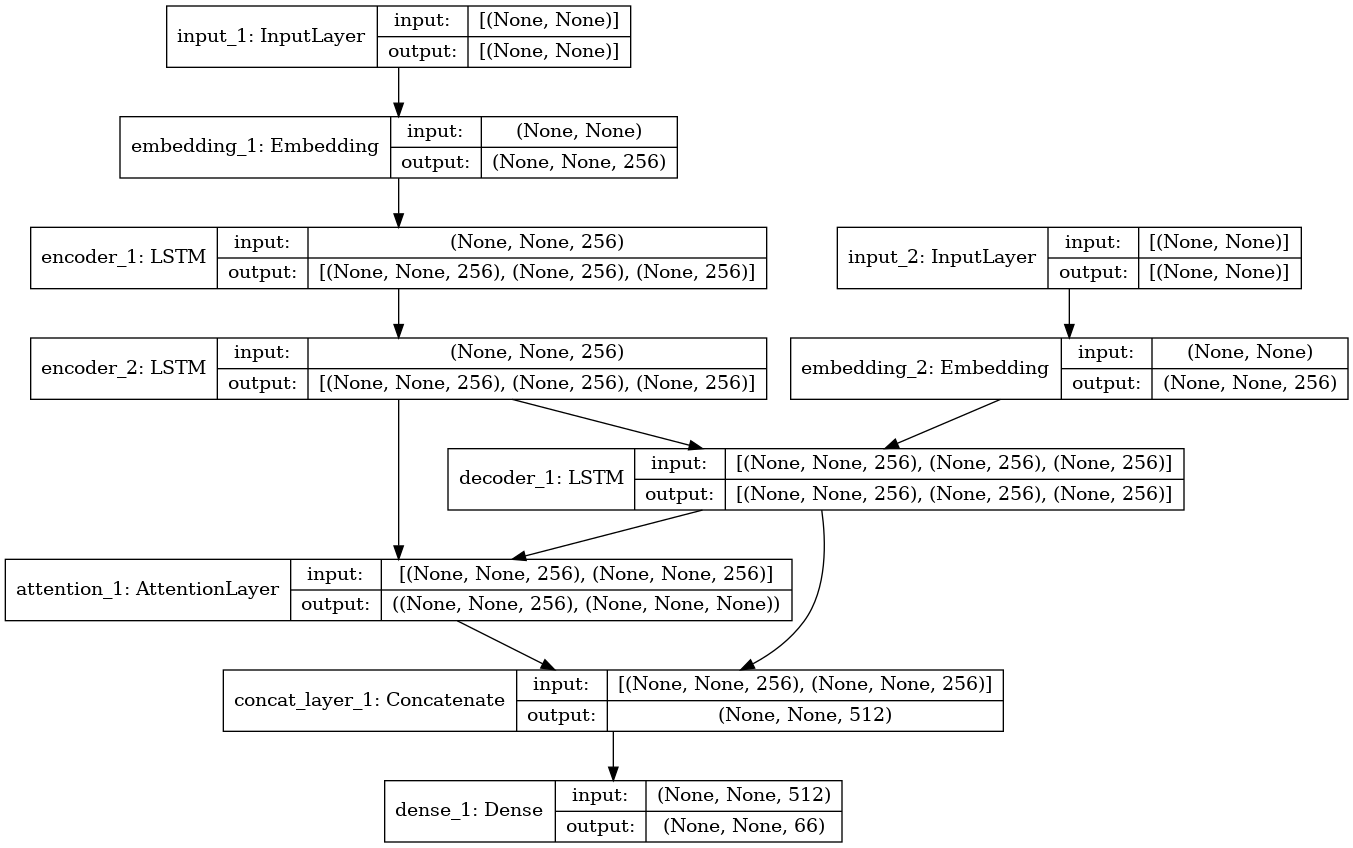

In [20]:
test2_acc, test2_exact_K_acc, test2_exact_acc, test2_loss, test2_true_out, \
test2_pred_out, test2_pred_scores, test2_attn_scores, model2 = test_model('ivfrjoke', test_enc_input, 
                                                                          test_dec_target, 
                                                                          max_decoder_seq_length, 
                                                                          target_char_enc, 
                                                                          target_char_dec, 
                                                                          True)

random_samples = [ 821, 1686, 2859, 3680,  200, 3241, 1538, 2881, 3214,  771]

_ = print_samples(test_inp, test2_true_out, test2_pred_out, test2_pred_scores, random_samples)
plot_model(model2, show_shapes=True)

### Attention heatmaps for best model

In [21]:
# Downloading a font which supports English + Hindi characters to be able to caption in matplotlib using both languages
!yes | wget -P fonts "https://www.fontsquirrel.com/fonts/download/vesper-libre"
%cd fonts
!yes | unzip vesper-libre
%cd ../

--2022-05-23 10:58:40--  https://www.fontsquirrel.com/fonts/download/vesper-libre
Resolving www.fontsquirrel.com (www.fontsquirrel.com)... 45.79.150.110, 2600:3c03::f03c:91ff:fe37:ba29
Connecting to www.fontsquirrel.com (www.fontsquirrel.com)|45.79.150.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 371600 (363K) [application/octet-stream]
Saving to: ‘fonts/vesper-libre’

vesper-libre        100%[===================>] 362.89K  1.44MB/s    in 0.2s    

2022-05-23 10:58:41 (1.44 MB/s) - ‘fonts/vesper-libre’ saved [371600/371600]

yes: standard output: Broken pipe
/kaggle/working/fonts
Archive:  vesper-libre
  inflating: VesperLibre-Regular.ttf  
  inflating: VesperLibre-Medium.ttf  
  inflating: VesperLibre-Bold.ttf    
  inflating: VesperLibre-Heavy.ttf   
  inflating: SIL Open Font License.txt  
yes: standard output: Broken pipe
/kaggle/working


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def plot_heatmaps(input, pred_out, pred_scores, attn_scores, wandb_log=False, rand_seq=None):
    '''
    Function to generate attention heatmaps for 9 samples in a 3 x 3 grid
    Arguments :
        input -- input words
        true_out -- true output as words
        pred_out -- K predicted output words
        pred_scores -- levenshtein distance for the predictions to the true output
        attn_scores -- attention scores
        wandb_log -- (bool, default : False) whether or not to log the image generated to WANDB
        rand_seq -- list of indices from the dataset passed for which the sample outputs are to be printed (If None, random 9 samples will be chosen)
                    (The length of list passed should be >= 9)
    Returns :
        rand_seq -- the list of indices for which sample outputs are printed
    '''
    no_samples = len(pred_out)
    if rand_seq is None:
        rand_seq = np.random.randint(no_samples, size=(9,))
    rand_seq = rand_seq[:9]
    
    plt.close('all')
    fig = plt.figure(figsize=(15,15))
    fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)
    plt.suptitle('Attention Heatmaps', fontsize='x-large')
    for i,ax in zip(rand_seq, axes.flat):
        K = len(pred_scores[i])
        k = np.argmin(pred_scores[i])
        im = ax.imshow(attn_scores[i,k,:len(pred_out[i][k])+1,:len(input[i])+1].T, vmin=0, vmax=1, cmap='magma')
        ax.set_xticks(range(len(pred_out[i][k])+1))
        ax.set_xticklabels(list(pred_out[i][k])+['<end>'], fontproperties=FontProperties(fname="fonts/VesperLibre-Regular.ttf"))
        ax.set_yticks(range(len(input[i])+1))
        ax.set_yticklabels(list(input[i])+['<end>'])
        ax.set_ylabel(u'Encoder Input')
        ax.set_xlabel(f'Decoder Output')
        ax.set_title(str(i) + r'$^{th}$ example of Test Set')
        ax.set_aspect("equal")
        ax.grid(False)

    # create colorbar
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
    # Log in WANDB
    if wandb_log:
        run = wandb.init(project="assignment3", entity="abisheks", reinit=True)
        wandb.log({'attention_heatmaps': fig})
        run.finish()

    plt.show()

    return rand_seq
    

<Figure size 1080x1080 with 0 Axes>

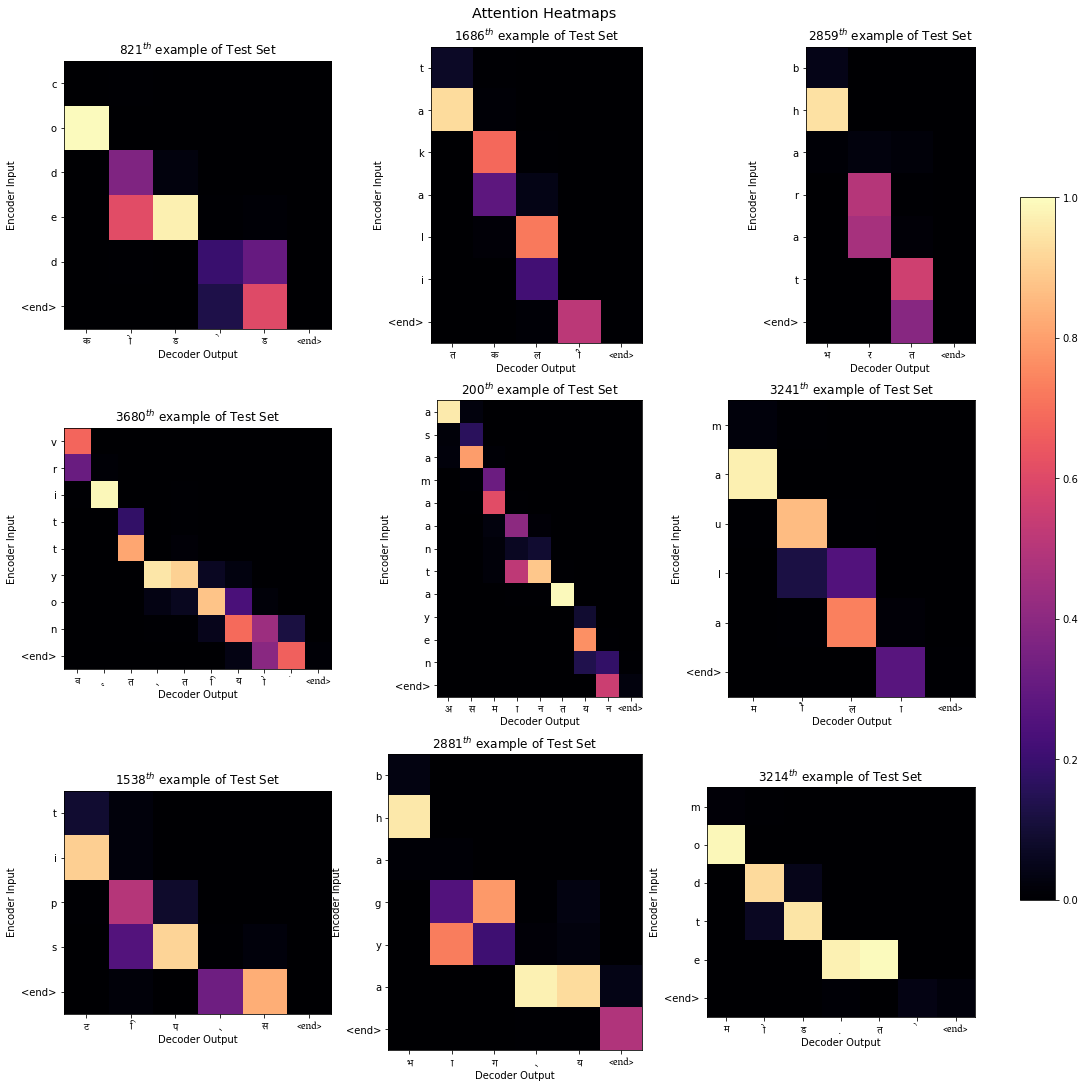

In [23]:
_ = plot_heatmaps(test_inp, test2_pred_out, test2_pred_scores, test2_attn_scores, False, random_samples)

### Visualizing attention connectivity for best model

In [24]:
def cstr(s, color=None):
  # Function to get text html element
  if color is None:
      return '''<text style="padding:2px; color:#C0C0C0"> {} </text>'''.format(s)
  return '''<text style="color:#000;background-color:{}; padding:2px; color:#FF6699"> {} </text>'''.format(color, s)

In [25]:
def print_connectivity(input, pred_out, pred_scores, attn_scores, dec_char_ind=0):
    '''
    Function to visualize attention for one index of decoder output of one sample
    Arguments :
        input -- sample input word
        pred_out -- K predicted output words for the sample
        pred_scores -- levenshtein distance for the predictions to the true output
        attn_scores -- attention scores
        dec_char_ind -- (default : 0) index of the character in decoder for which the visuzalization is to be done
    Returns :
        -- None --
    '''
    K = len(pred_scores)
    print('-'*20 + f' Visualizing attention for Top {K} predictions (in decreasing order of probabilities) ' + '-'*20)
    print('')
    html_str = '''
    <table style="border:2px solid black; border-collapse:collapse; font-size:1.5em">
    <caption> <strong>INPUT : </strong> {} </caption>
    <tr>
    <th style="border:1px solid black;padding:10px;text-align:center"> Character in Prediction Focussed </th>
    <th style="border:1px solid black;padding:10px;text-align:center"> Attention Visualization </th>
    </tr>
    '''.format(input)
    for k in range(K):  
        char = pred_out[k][dec_char_ind] if dec_char_ind < len(pred_out[k]) else '&lt end &gt' if dec_char_ind == len(pred_out[k]) else '&lt blank &gt'
        middle_char = pred_out[k][dec_char_ind] if dec_char_ind < len(pred_out[k]) else ''
        end_str = pred_out[k][dec_char_ind+1:] if dec_char_ind < len(pred_out[k])-1 else ''
        html_str += '''
        <tr>
        <td style="border:1px solid black;padding:10px;text-align:center"> character at index {} of {}<span style="color: #FF1493">{}</span>{} <br/> ({}) </td>
        <td style="border:1px solid black;padding:10px;text-align:center">
        '''.format(dec_char_ind, pred_out[k][:dec_char_ind], middle_char, end_str, char)
        for i,c in enumerate(input):
            html_str += '''
            {}
            '''.format(cstr(c, get_clr(attn_scores[k,dec_char_ind,i], 'YlGnBu')))
        html_str += '''
        </td>
        </tr>
        '''
    html_str += '''
    </table>
    '''
    display(html_print(html_str))


In [26]:
def visualize_attention(sample_ind=0, dec_char_ind=0):
    print_connectivity(test_inp[sample_ind], test2_pred_out[sample_ind], test2_pred_scores[sample_ind], test2_attn_scores[sample_ind], dec_char_ind)

In [27]:
@interact(sample_ind = IntSlider(min=0, max=len(test_inp)-1, step=1, value=10, layout=Layout(width='800px')))
def f(sample_ind):
    print(f'Input : {test_inp[sample_ind]}')
    print(f'Top {len(test2_pred_out[sample_ind])} predictions : ')
    mx_len = 0
    for pred in test2_pred_out[sample_ind]:
        print(pred)
        mx_len = max(mx_len, len(pred))
    
    @interact(character_ind = widgets.IntSlider(min=0, max=mx_len-1, step=1, value=0))
    def g(character_ind):
        visualize_attention(sample_ind, character_ind)

interactive(children=(IntSlider(value=10, description='sample_ind', layout=Layout(width='800px'), max=4357), O…